# Mod 5 Project - Ethical recognition of potential loan defaults through machine learning

## Problem framing

Every year default loans cost the banking industry on average $10,000 USD according to the [Bank of England Statistics pages]((https://www.bankofengland.co.uk/statistics)) and with [1 in 5 calls to the Samaritans in the UK](https://tinyurl.com/vponqo5) now dues to "extreme financial distress", it is imperative we take advantage of advances in data processing and machine leanring to ensure we are only lending money to people who can afford to repay.

We are fortunate in he banking industry to be able to have access to lot of data surrounding how loans are are approved and the results of those loans (either full repayment or default). We are also fortunate to be able to have access to different machine learning models to be able to look for patters in the data to provide insights into the types of questions we should be asking people who will potentially borrow money from us. As well as devise machine learning models that are able to predict with a higher degree of accuracy than our current methods in order to predict if a loan will be repaid or default.



## Success Metrics

According to our current loans dataset we get this right **70% of the time**, therefore **success is**:

> 1) Building a model that predicts defualt loans from our current data with an error **less than 30%**
>
> 2) We are able to examine the current dataset, in order to find what factors most accurately predict when a loan will default, so we can improve our application process overall

Let's get to it

## Imports and Data Ingestion

In [1]:
#import libraries

import mod_5_project_helper as hp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#set environment

hp.set_environment()
%matplotlib inline

#import data

df = pd.read_csv("data.csv")

## Data Cleanup

In [2]:
#call function to clean up the dataset for training/analysis
#see accompanying script for cleanup details

df = hp.data_cleanup(df)

## Cleaned Dataset Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_status                   26401 non-null  object 
 1   loan_amount                   26401 non-null  float64
 2   term                          26401 non-null  object 
 3   credit_score                  26401 non-null  float64
 4   annual_income                 26401 non-null  float64
 5   years_in_current_job          26401 non-null  object 
 6   home_ownership                26401 non-null  object 
 7   loan_purpose                  26401 non-null  object 
 8   monthly_debt                  26401 non-null  float64
 9   years_of_credit_history       26401 non-null  float64
 10  months_since_last_delinquent  26401 non-null  float64
 11  number_of_open_accounts       26401 non-null  float64
 12  number_of_credit_problems     26401 non-null  float64
 13  c

We have 17 features with an interesting mix of catgorical and continuous varables. It should be noted the target variable for our predictions is **loan_status**, which as the name implies describes whether a loan has been fully paid or defaulted. This has been encoded to a binary, numeric feature for the purposes of training. This is **loan_status_binary_value** with 1 = fully_paid and 0 = default.

In [4]:
df.shape

(26401, 17)

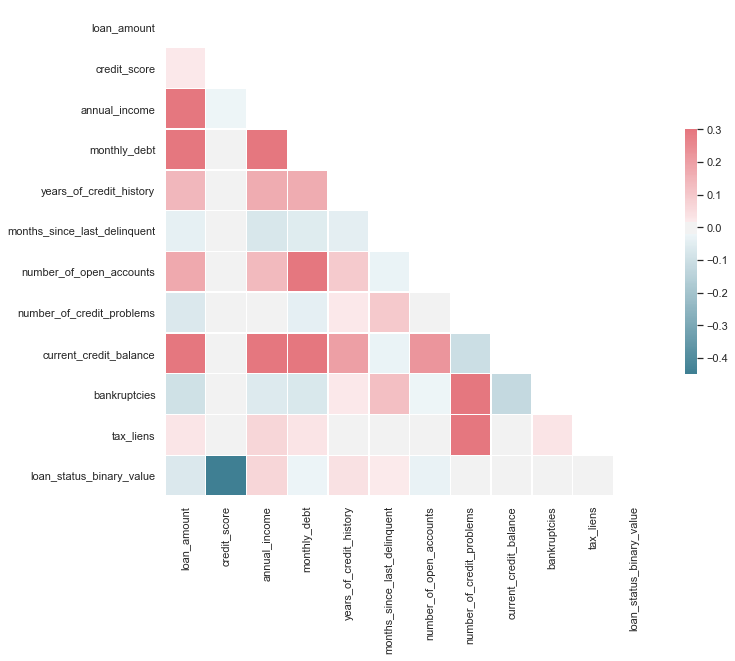

In [5]:
hp.correlation_matrix(df);

Looking at a correlation matrix of all numeric variables in the dataframe, we can see a strong correlation between credit_score and loan_status_binary_value which is to be expected. Clearly the processes currently being used are having some success and so building on this success will be challenging, but beneficial if it can be achieved.

## Class Imbalance Issues

In [6]:
df.groupby(df.loan_status).count()

,loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,loan_purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens,loan_status_binary_value
loan_status,,,,,,,,,,,,,,,,
default,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479,7479
fully_paid,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922,18922


Looking at our target variable of loan_status we can see we have a roughly 70/30 split in classes. If we undersampled the fully_paid class we would lose roughly 1/5 of our data and as this is not a large dataset that is not something we would like to try. It should be noted that we did try oversampling the default class using a [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) algorithm but the performance wasn't optimisal and so we decided to leave the class balance as is. 

## Train, validate, test split, K-folds and one-hot encoding

In [6]:
#define X and y columns for training, validation and testing

X = df.drop(columns = ["loan_status", "loan_status_binary_value"])
y = df.loan_status_binary_value

In [7]:
#define randomized train, validation and test data subsets
#the test set will be left to evaluate the final model at the end of the process
#the train subset will be used to train the model and the validation subset will 
# be a 'clean' dataset used to validate the training

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

In [8]:
#call function to one-hot encode categorical variables in X_train and X_val subsets
#see comments in helper script for details

X_train_all_numbers, X_val_all_numbers = hp.one_hot_encoding(X_train, X_val);

In [9]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42) #initialise cross validation object

## Logistic Regression

In [10]:
log_reg = LogisticRegression()
log_reg.fit(X_train_all_numbers, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
y_predicted = log_reg.predict(X_train_all_numbers)

In [12]:
accuracy_score(y_train, y_predicted)

0.7827296401515151

In [13]:
confusion_matrix(y_train, y_predicted)

array([[ 1340,  3524],
       [  147, 11885]])

In [14]:
y_hat_train = log_reg.predict(X_train_all_numbers)
y_hat_test = log_reg.predict(X_val_all_numbers)


from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('\nTraining Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_val, y_hat_test))
print('\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_val, y_hat_test))
print('\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_val, y_hat_test))
print('\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_val, y_hat_test))


Training Precision:  0.7713024855603868
Testing Precision:  0.7789473684210526


Training Recall:  0.987782579787234
Testing Recall:  0.9898858075040783


Training Accuracy:  0.7827296401515151
Testing Accuracy:  0.7888257575757576


Training F1-Score:  0.8662220764549398
Testing F1-Score:  0.8718390804597701


In [15]:
y_score = log_reg.fit(X_train_all_numbers, y_train).decision_function(X_val_all_numbers)

fpr, tpr, thresholds = roc_curve(y_val, y_score)

In [16]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.6597837760233762


train: 0.68 test: 0.66


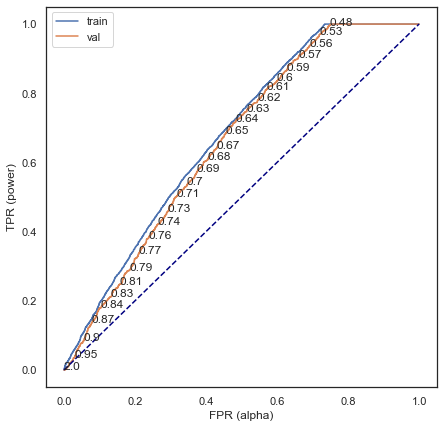

In [17]:
hp.scores(log_reg,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(log_reg,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

In [18]:
opt_log = LogisticRegression(random_state = 42)

penalty = ['l1', 'l2']
C = [0.001,0.01,0.1,1,10,100,1000]

hyperparameters = dict(C=C, penalty=penalty)

#param_grid = {'max_depth':range(10,50,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(opt_log,hyperparameters,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)

train: 0.68 test: 0.66
{'C': 10, 'penalty': 'l2'}


train: 0.68 test: 0.66


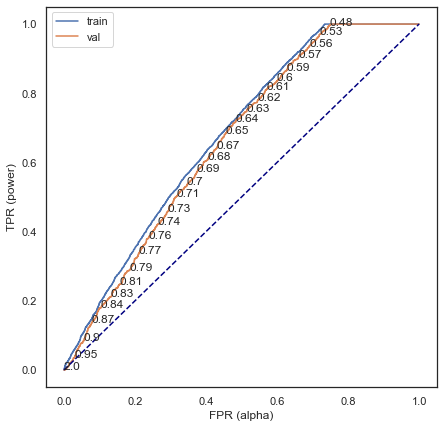

In [19]:
hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

In [20]:
opt_log = LogisticRegression(random_state = 42)

penalty = ['l1', 'l2']
C = [4,5,6,7,8,9,10,11,20]

hyperparameters = dict(C=C, penalty=penalty)

opt_model = GridSearchCV(opt_log,hyperparameters,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)

train: 0.68 test: 0.66
{'C': 6, 'penalty': 'l2'}


train: 0.68 test: 0.66


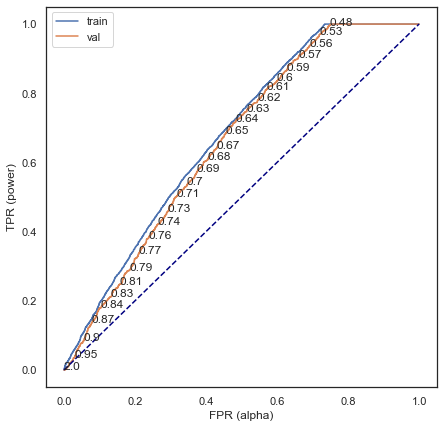

In [21]:
hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

## Decision Trees

In [11]:
#instantiate tree classifier object

tree_clf = DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 20, random_state = 42)

In [12]:
tree_clf.fit(X_train_all_numbers, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

train: 0.86 test: 0.68


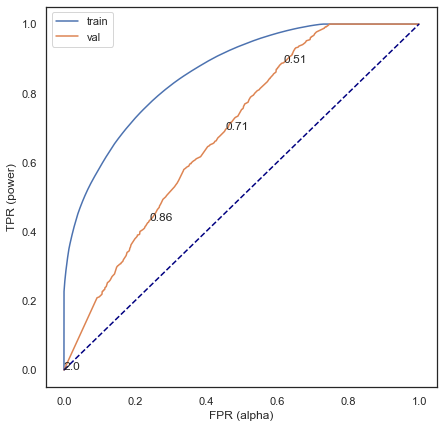

In [13]:
hp.scores(tree_clf,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(tree_clf,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.74 test: 0.72
{'max_depth': 10, 'min_samples_leaf': 500}


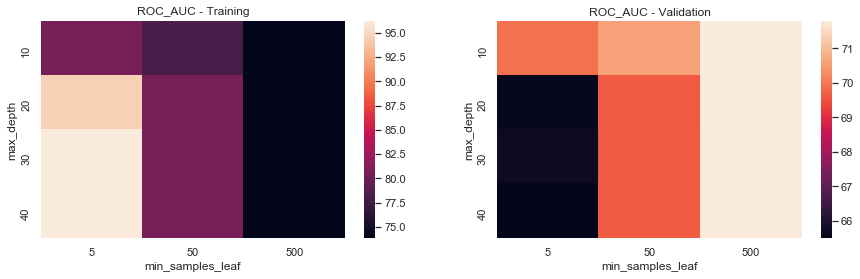

In [14]:
opt_tree = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_depth':range(10,50,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(opt_tree,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
hp.opt_plots(opt_model)

train: 0.74 test: 0.72


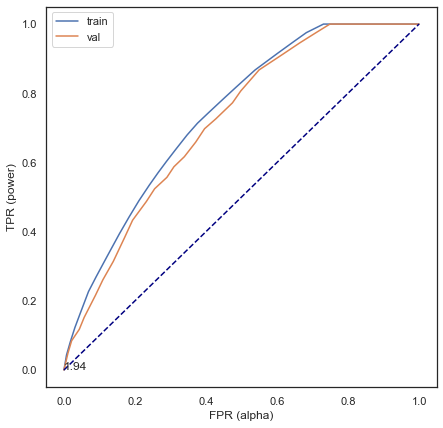

In [16]:
hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.73 test: 0.71
{'max_depth': 10, 'min_samples_leaf': 700}


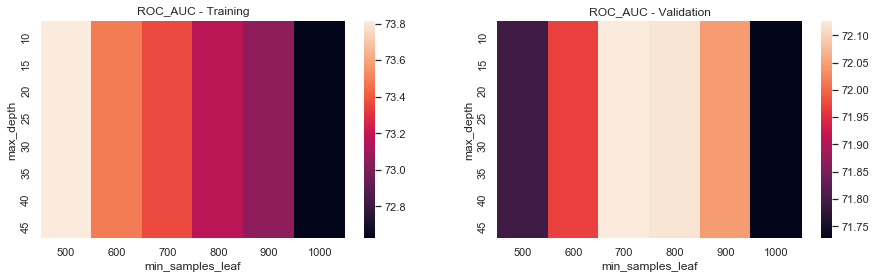

In [18]:
opt_tree = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_depth':range(10,50,5),'min_samples_leaf':[500, 600, 700, 800, 900, 1000]}

opt_model = GridSearchCV(opt_tree,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
hp.opt_plots(opt_model)

train: 0.73 test: 0.71


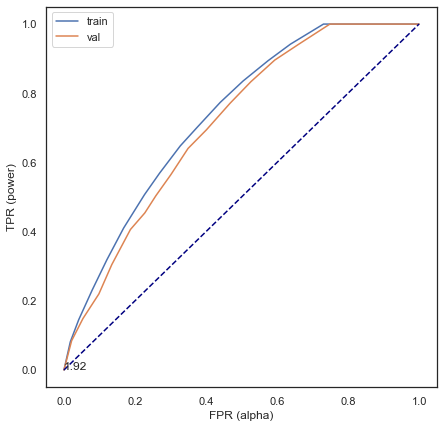

In [19]:
hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.73 test: 0.71
{'max_depth': 7, 'min_samples_leaf': 770}


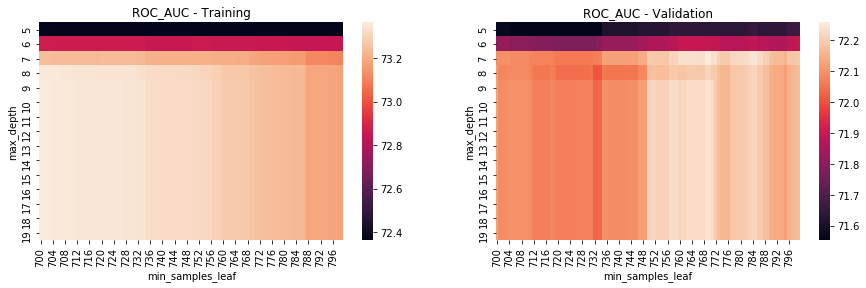

In [98]:
opt_tree = DecisionTreeClassifier(random_state = 42)

param_grid = {'max_depth':range(5,20),'min_samples_leaf':range(700,800)}

opt_model = GridSearchCV(opt_tree,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
hp.opt_plots(opt_model)

train: 0.73 test: 0.71


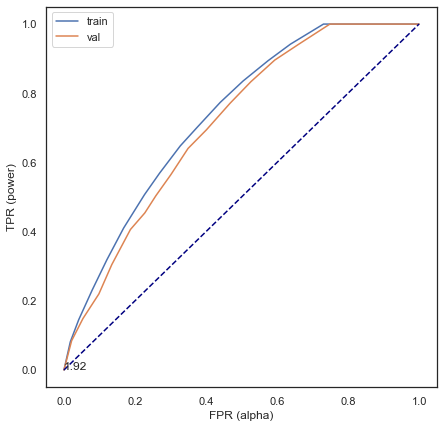

In [20]:
hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

## Random Forests

In [99]:
forest_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1, random_state = 42)

In [103]:
forest_clf.fit(X_train_all_numbers,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

train: 0.74 test: 0.73


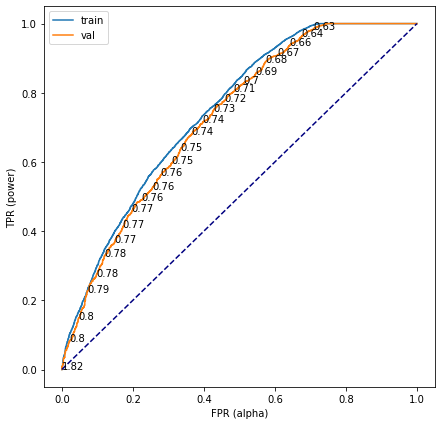

In [104]:
hp.scores(forest_clf,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(forest_clf,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.74 test: 0.73
{'max_depth': 10, 'min_samples_leaf': 50}


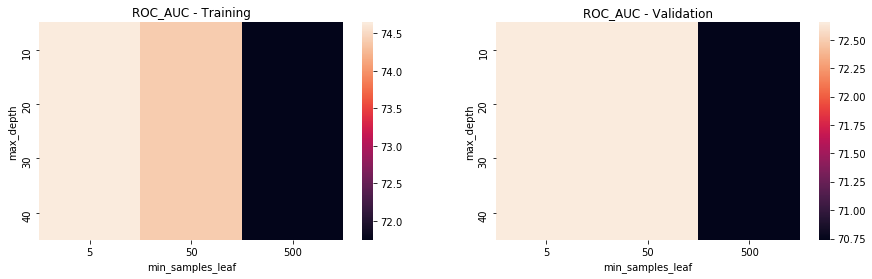

In [107]:
param_grid = {'max_depth':range(10,50,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(forest_clf,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
hp.opt_plots(opt_model)

train: 0.74 test: 0.73


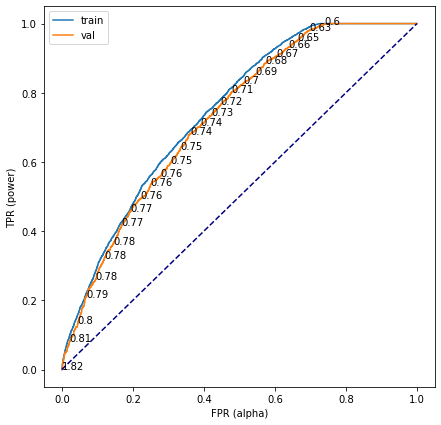

In [109]:
hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
hp.roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

train: 0.74 test: 0.73
{'max_depth': 9, 'min_samples_leaf': 31}


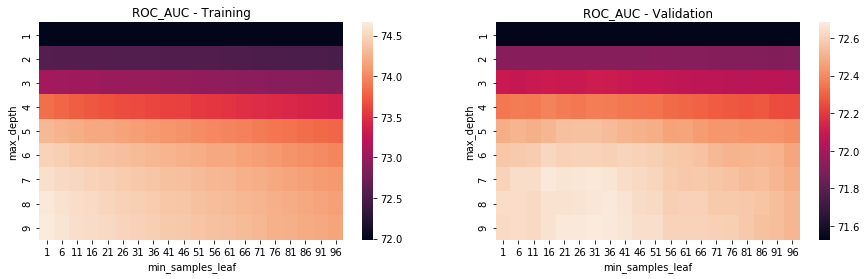

In [110]:
param_grid = {'max_depth':range(1,10),'min_samples_leaf':range(1,100,5)}

opt_model = GridSearchCV(forest_clf,param_grid,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

hp.scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
hp.opt_plots(opt_model)

## Winning Model

We have evaluated 3 models: logistic regression, a decision tree and a random forest. We optimised the hyperparamters for each and plotted a ROC curve in order to determine the performance. What we found was that the AUC metric increased with each model until we achived an AUC of 0.73 with the decision tree on the validation data set when doing 10 x K-fold. This is the best performing model out of all of the candidates we test (which was around 3,000 different models) and next steps are to determine what is the threshhold for our model performance taking into account business imperatives. 

## Threshold Calculations

In [22]:
#formula to calculate M for use in optimum threshold formula

paid_loans = df[df["loan_status"] == "fully_paid"]
sum_paid_loans = paid_loans["loan_amount"].sum()
default_loans = df[df["loan_status"] == "default"]
sum_default_loans = default_loans["loan_amount"].sum()
def calculate_m(num_of_defaults, num_of_all_loans, fp, tn, fn, tp):
    m = 0.0
    prevelence = (num_of_defaults/num_of_all_loans)
    m = (((1-prevelence)/prevelence)*((fp-tn)/(fn-tp)))
    return m
tp = 0.1*sum_paid_loans
tn = sum_default_loans + 0.1*(sum_default_loans)
fp = confusion_matrix(y_train, y_predicted)[0,1] + 0.1*(confusion_matrix(y_train, y_predicted)[0,1] )
fn = confusion_matrix(y_train, y_predicted)[1,0]
m_val = calculate_m(7479, 26471, fp, tn, fn, tp)
m_val

11.982160752590675

In [23]:
mfpr = m_val*fpr

In [33]:
fm = tpr - mfpr

In [35]:
fm.sort()

In [31]:
fm.sort()

In [40]:
fm[0]

-10.982160752590675

Our highest value of fm is a negative number as we are supposed to be dealing with probablilities which means that this value is invalid. We would appreciate some steer on this please

## Next Steps

Next steps are to review our threshold calculation above as it doesn't seem correct and to review the performance of the model against the test dataset, which is something we would have done if we had more time. Assuming satisfactory performance we would then put this into production.

In [41]:
opt_forest_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1, random_state = 42, max_depth=9, min_samples_leaf=31)

In [43]:
opt_forest_clf.fit(X_train_all_numbers,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=31, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
opt_forest_clf.feature_importances_

array([2.03833179e-02, 7.08576257e-01, 5.09583752e-02, 1.54774443e-02,
       1.18144820e-02, 6.29333662e-03, 6.38634857e-03, 1.12241979e-02,
       3.51586110e-04, 2.00030644e-03, 6.50347373e-02, 6.61070395e-02,
       2.95394326e-04, 1.63742056e-03, 4.85320535e-04, 2.40667291e-04,
       2.34356478e-04, 1.46907071e-04, 1.01103391e-04, 3.56692302e-04,
       2.73419218e-04, 4.00725992e-05, 4.98846264e-03, 1.17704380e-02,
       6.01855530e-04, 9.02280080e-03, 3.50406887e-03, 3.69554434e-04,
       1.31955914e-05, 3.54766491e-04, 0.00000000e+00, 4.73306931e-04,
       0.00000000e+00, 2.92258915e-04, 1.58456466e-04, 3.20524327e-05,
       0.00000000e+00])